In [1]:
import pandas as pd
train_data=pd.read_csv("featureEng_train_data.csv")
test_data=pd.read_csv("featureEng_test_data.csv")

In [2]:
train_data

Unnamed: 0  Delivery_person_Age  Delivery_person_Ratings  \
0               0                 38.0                      4.7   
1               1                 21.0                      4.9   
2               2                 29.0                      4.8   
3               3                 22.0                      4.8   
4               4                 20.0                      4.7   
...           ...                  ...                      ...   
27982       28946                 38.0                      4.5   
27983       28947                 33.0                      4.6   
27984       28948                 38.0                      4.9   
27985       28949                 37.0                      4.7   
27986       28950                 28.0                      4.8   

      Weather_conditions Road_traffic_density  Vehicle_condition  \
0                  Sunny                  Low                  2   
1                 Cloudy                 High                  0   
2                  Sunny                  Low                  1   
3                    Fog                 High                  2   
4                 Stormy               Medium                  0   
...                  ...                  ...                ...   
27982              Sunny               Medium                  1   
27983         Sandstorms               Medium                  2   
27984             Cloudy                  Low                  2   
27985              Windy                  Low                  0   
27986              Windy               Medium                  2   

      Type_of_order   Type_of_vehicle  multiple_deliveries Festival  \
0            Drinks  electric_scooter                  0.0       No   
1              Meal        motorcycle                  0.0       No   
2              Meal        motorcycle                  0.0       No   
3             Snack           scooter                  0.0       No   
4            Buffet        motorcycle                  0.0       No   
...             ...               ...                  ...      ...   
27982        Drinks           scooter                  0.0       No   
27983        Buffet  electric_scooter                  1.0       No   
27984          Meal        motorcycle                  0.0       No   
27985          Meal        motorcycle                  1.0       No   
27986        Drinks  electric_scooter                  1.0       No   

                City  Time_taken (min)  Distance_km  Time_Differece_in_minutes  
0              Urban                14     3.029513                       15.0  
1      Metropolitian                28     5.959019                       10.0  
2              Urban                16     1.558099                        5.0  
3      Metropolitian                30     1.489800                       10.0  
4      Metropolitian                17     9.315745                       15.0  
...              ...               ...          ...                        ...  
27982          Urban                16    13.894916                     1097.5  
27983          Urban                33     6.105310                       15.0  
27984  Metropolitian                28    14.152801                      -60.0  
27985  Metropolitian                20    12.074047                    -1307.5  
27986  Metropolitian                23    17.297866                        5.0  

[27987 rows x 14 columns]

In [3]:
train_data.drop(["Unnamed: 0","Time_Differece_in_minutes"],axis=1,inplace=True)
test_data.drop(["Unnamed: 0","Time_Differece_in_minutes"],axis=1,inplace=True)

In [4]:
train_data.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken (min)', 'Distance_km'],
      dtype='object')

In [5]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype=='object']
num_cols=[col for col in train_data.drop("Time_taken (min)",axis=1).columns if train_data[col].dtype in ['int64','float64']]

In [6]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedKFold,KFold,StratifiedKFold
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


X_train=train_data.drop("Time_taken (min)",axis=1)
y_train=train_data['Time_taken (min)']
X_test=test_data.drop("Time_taken (min)",axis=1)
y_test=test_data['Time_taken (min)']

In [ ]:
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

lasso_pipe= Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor",Lasso())
])
rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
   'regressor__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
}
lasso_bayes_search = BayesSearchCV(estimator=lasso_pipe, search_spaces=param_space, n_iter=50, cv=rkf, n_jobs=-1, random_state=42)
lasso_bayes_search.fit(X_train, y_train)

best_alpha = lasso_bayes_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_results = cross_validate(lasso_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

C:\Users\cheen\AppData\Roaming\Python\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.1]
  warnings.warn(
C:\Users\cheen\AppData\Roaming\Python\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [1]
  warnings.warn(
C:\Users\cheen\AppData\Roaming\Python\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.01]
  warnings.warn(
C:\Users\cheen\AppData\Roaming\Python\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.01]
  warnings.warn(
C:\Users\cheen\AppData\Roaming\Python\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] befor

Mean absolute Error: 4.857539357048019
R-squared on holdout set: 0.574617826067356
Adjusted R-squared on holdout set: 0.5742059998400715


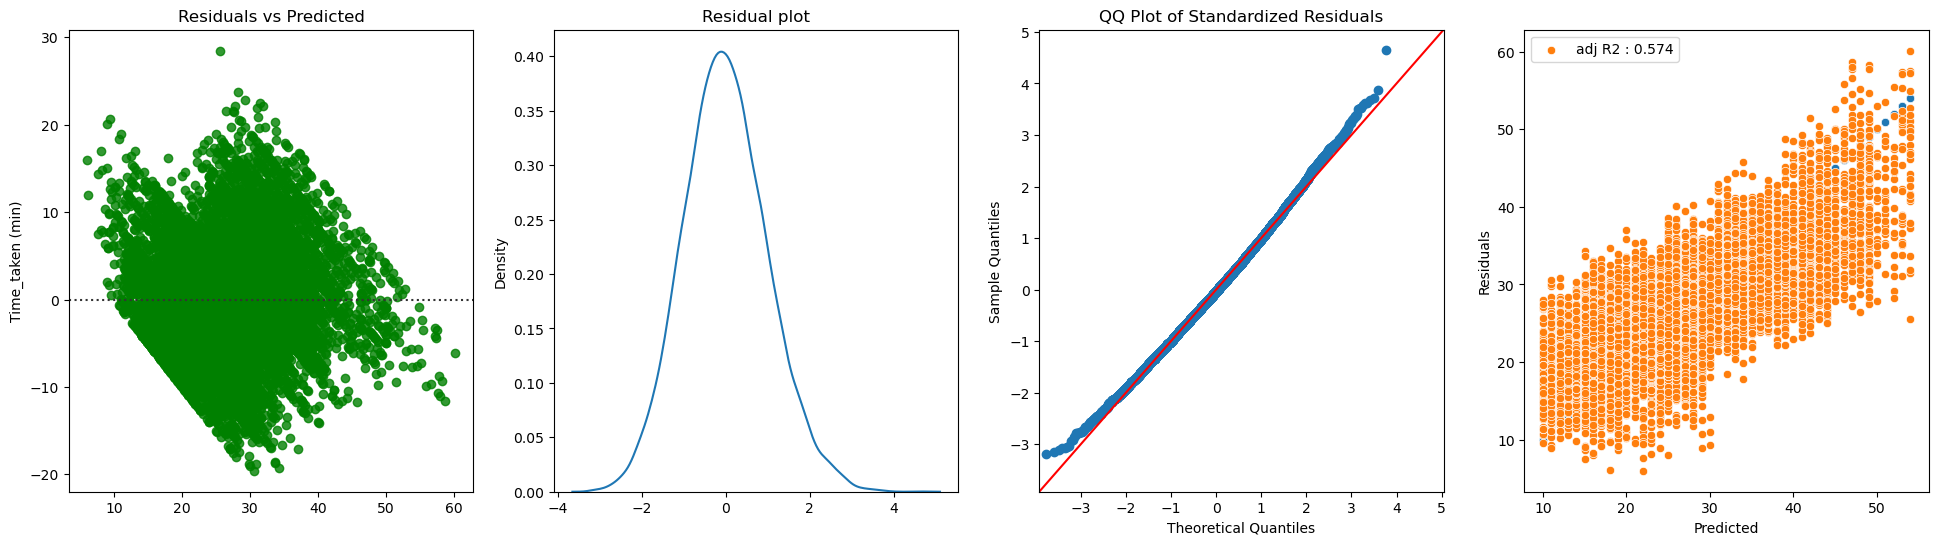

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sc=StandardScaler()
predictions = cross_val_predict(lasso_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
plt.show()

In [ ]:
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor",Ridge())
])

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
  'regressor__alpha': [1, 10, 100, 1000] ,
}
ridge_bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=50, cv=rkf, n_jobs=-1, random_state=42)
ridge_bayes_search.fit(X_train, y_train)

best_alpha = ridge_bayes_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_results = cross_validate(ridge_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')